In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [16]:
train_participants = pd.read_csv('data/train_participants.csv')
test_participants = pd.read_csv('data/test_participants.csv')

In [17]:
# Uploading the voxel data

train_data = np.load('data/train_vbm.npz', allow_pickle=True)
test_data = np.load('data/test_vbm.npz', allow_pickle=True)
print(train_data.files)

X_train_voxels = train_data['imgs_arr']
X_test_voxels = test_data['imgs_arr']

train_ids = train_data['participant_id']
test_ids = test_data['participant_id']

X_train_voxels.shape, X_test_voxels.shape, train_ids.shape, test_ids.shape

['imgs_arr', 'mask_arr', 'affine', 'participant_id']


((410, 1, 121, 145, 121), (103, 1, 121, 145, 121), (410,), (103,))

In [18]:
train_labels = train_participants.set_index('participant_id').loc[train_ids]['diagnosis'].values
test_labels = test_participants.set_index('participant_id').loc[test_ids]['diagnosis'].values

# Convert to binary labels
y_train_binary = np.where(train_labels == "schizophrenia", 1, 0)
y_test_binary = np.where(test_labels == "schizophrenia", 1, 0)


In [19]:
# Applying the mask to drop the non-brain voxels
mask = train_data['mask_arr']
X_train_voxels_masked = X_train_voxels * mask
X_test_voxels_masked = X_test_voxels * mask

In [20]:
#Verifying that the mask is applied correctly
print(type(X_train_voxels))
print(X_train_voxels.shape)
print(X_train_voxels_masked.shape)
print(np.count_nonzero(X_train_voxels))
print(np.count_nonzero(X_train_voxels_masked))

<class 'numpy.ndarray'>
(410, 1, 121, 145, 121)
(410, 1, 121, 145, 121)
175334787
134205346


In [21]:
#Normalization

X_train_voxels_masked = X_train_voxels_masked / np.max(X_train_voxels_masked)
X_test_voxels_masked = X_test_voxels_masked / np.max(X_test_voxels_masked)

# Add channel dimension for CNN
# X_train_voxels_masked = X_train_voxels_masked[..., np.newaxis]  # (samples, 121, 145, 121, 1)
# X_test_voxels_masked = X_test_voxels_masked[..., np.newaxis]


In [22]:
X_train_voxels_masked.shape, X_test_voxels_masked.shape

((410, 1, 121, 145, 121), (103, 1, 121, 145, 121))

In [23]:
X_train_voxels_masked = np.squeeze(X_train_voxels_masked, axis=1)
X_test_voxels_masked = np.squeeze(X_test_voxels_masked, axis=1)

X_train_voxels_masked = X_train_voxels_masked[..., np.newaxis]  # (samples, depth, height, width, channels)
X_test_voxels_masked = X_test_voxels_masked[..., np.newaxis]

print("Train voxel shape after squeeze:", X_train_voxels_masked.shape)  # Should be (410, 121, 145, 121, 1)
print("Test voxel shape after squeeze:", X_test_voxels_masked.shape)    # Should be (103, 121, 145, 121, 1)


Train voxel shape after squeeze: (410, 121, 145, 121, 1)
Test voxel shape after squeeze: (103, 121, 145, 121, 1)


In [24]:
del X_train_voxels, X_test_voxels, mask, train_data, test_data


In [25]:
# import torch
# print(torch.cuda.device_count())
# print(torch.cuda.is_available())
# print(torch.get_num_threads())


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
import numpy as np


In [32]:
def build_simplified_cnn(input_shape):
    model = Sequential([
        Conv3D(8, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(2, 2, 2)),
        BatchNormalization(),

        Conv3D(16, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.3),  # Less dropout due to reduced complexity
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

# Train the simplified model
model = build_simplified_cnn(input_shape)
history = model.fit(
    X_train_voxels_masked, y_train_binary,
    validation_split=0.2,
    epochs=30,
    batch_size=4,  # Smaller batch size
    callbacks=[early_stopping]
)


C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.5209 - auc_1: 0.4843 - loss: 4.0152 - val_accuracy: 0.4268 - val_auc_1: 0.4498 - val_loss: 0.6960
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.5592 - auc_1: 0.5000 - loss: 0.6931 - val_accuracy: 0.4268 - val_auc_1: 0.4532 - val_loss: 0.6983
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.5356 - auc_1: 0.5000 - loss: 0.6931 - val_accuracy: 0.4268 - val_auc_1: 0.4599 - val_loss: 0.6990
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.5861 - auc_1: 0.4819 - loss: 0.6929 - val_accuracy: 0.4024 - val_auc_1: 0.4131 - val_loss: 0.6972
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.5647 - auc_1: 0.5000 - loss: 0.6929 - val_accuracy: 0.5610 - val_auc_1: 0.5109 - val_loss: 0.6929
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.5203 - auc_1: 0.5000 - loss: 0.6931 - val_accuracy: 0.5732 - val_auc_1: 0.5000 - val_loss: 0.6928
Epoch 7/30

KeyboardInterrupt: 

In [30]:
# Evaluate on test data
test_loss, test_accuracy, test_auc = model.evaluate(X_test_voxels_masked, y_test_binary)
y_pred_proba = model.predict(X_test_voxels_masked).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Metrics
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)
print("Balanced Accuracy:", balanced_accuracy_score(y_test_binary, y_pred))
print("Classification Report:\n", classification_report(y_test_binary, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 871ms/step - accuracy: 0.4562 - auc: 0.5000 - loss: 9.5511
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 727ms/step
Test Accuracy: 0.4660194218158722
Test AUC: 0.5
Balanced Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.47      1.00      0.64        48

    accuracy                           0.47       103
   macro avg       0.23      0.50      0.32       103
weighted avg       0.22      0.47      0.30       103



C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: 

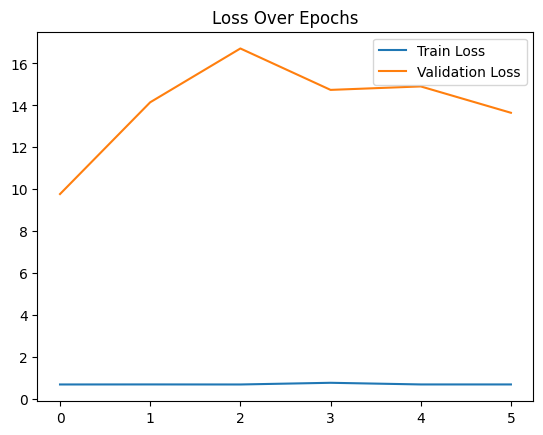

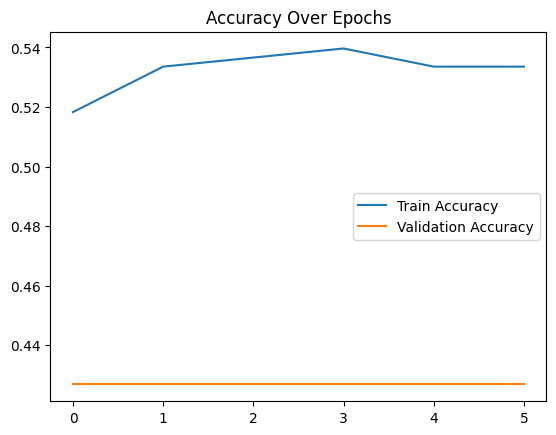

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()
